In [23]:
import numpy as np
import random
import os
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

prepare data

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

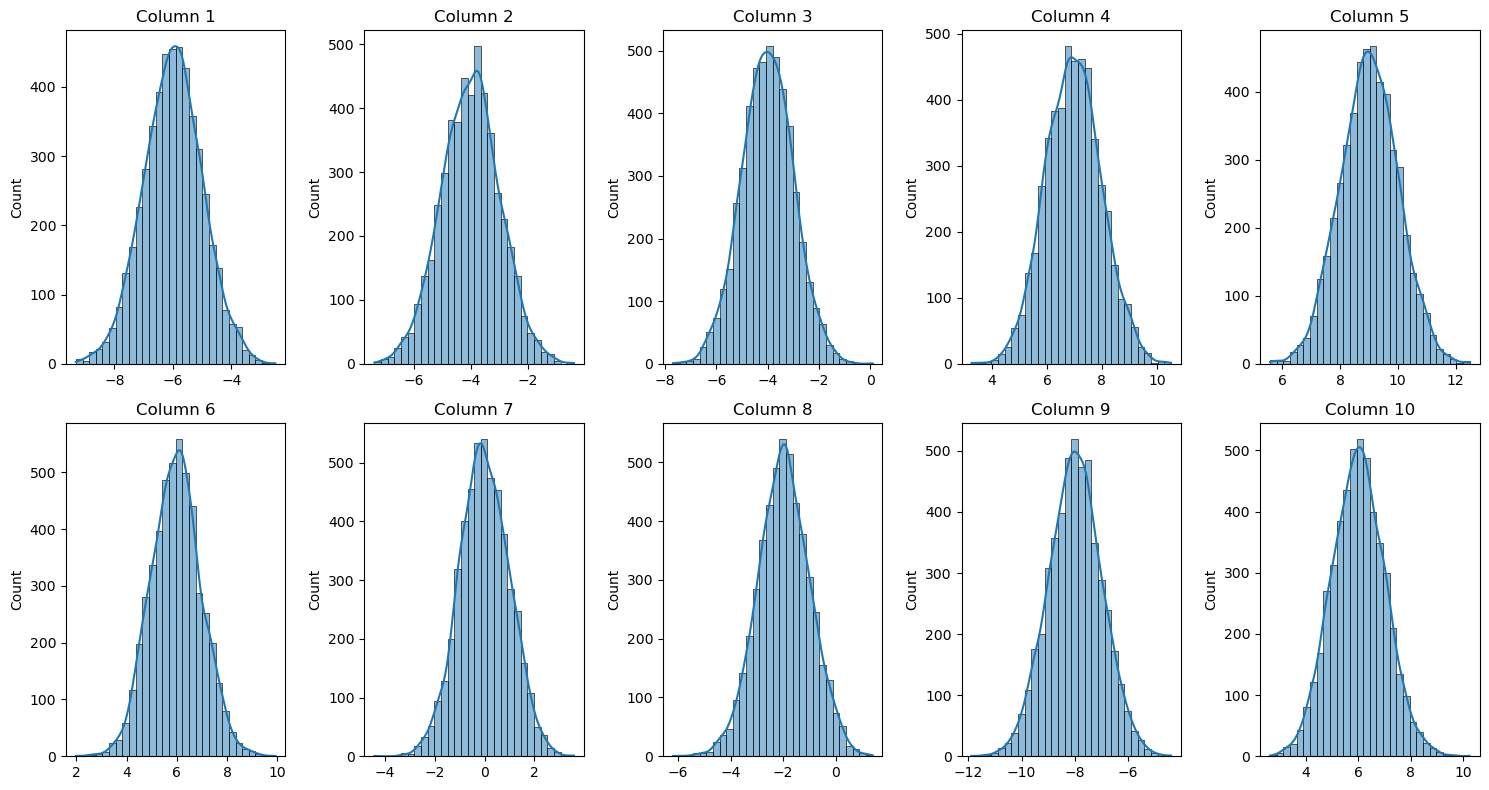

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
data_size = 5000
np.random.seed(64)
# Generate a random integer array 'a' with shape (10, 1)
a = np.random.randint(-10, 10, size=(10, 1))

# Flatten 'a' to create the mean vector for the multivariate normal distribution
mean = a.flatten()

# Generate multivariate normal data 'b' with shape (1000, 10)
b = np.random.multivariate_normal(mean=mean, cov=np.eye(10), size=data_size)

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Flatten the 2x5 axes array for easy iteration
axes = axes.flatten()

# Loop through each column of 'b' and plot its histogram on the corresponding subplot
for i in range(10):
    sns.histplot(b[:, i], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Column {i+1}')  # Set the title for each subplot

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


network arcitecture

In [25]:
class Backbone(nn.Module):
    def __init__(self, n_steps, input_dim = 2):
        super().__init__()
        self.linear_model1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Dropout(0.2),
            nn.GELU()
        )
        # Condition time t
        self.embedding_layer = nn.Embedding(n_steps, 256)
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.Dropout(0.2),
            nn.GELU(),
            
            nn.Linear(512, 512),
            nn.Dropout(0.2),
            nn.GELU(),
            
            nn.Linear(512, input_dim),
        )
    def forward(self, x, idx):        
        x = self.linear_model2(self.linear_model1(x) + self.embedding_layer(idx))
        return x


forward network

In [26]:
class Model(nn.Module):
    def __init__(self, device, beta_1, beta_T, T, input_dim):
        '''
        The epsilon predictor of diffusion process.

        beta_1    : beta_1 of diffusion process
        beta_T    : beta_T of diffusion process
        T         : Diffusion Steps
        input_dim : a dimension of data

        '''
        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = Backbone(T, input_dim)
        
        self.to(device = self.device)

    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        output, epsilon, alpha_bar = self.forward(x, idx=idx, get_target=True)
        loss = (output - epsilon).square().mean()
        return loss

        
    def forward(self, x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (epsilon prediction)

        '''

        if idx == None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device = self.device)
            used_alpha_bars = self.alpha_bars[idx][:, None]
            epsilon = torch.randn_like(x)
            x_tilde = torch.sqrt(used_alpha_bars) * x + torch.sqrt(1 - used_alpha_bars) * epsilon
            
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device = self.device).long()
            x_tilde = x
            

            
        output = self.backbone(x_tilde, idx)
        
        return (output, epsilon, used_alpha_bars) if get_target else output
        

sampling function

In [27]:
class DiffusionProcess():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, datadim):
        '''
        beta_1        : beta_1 of diffusion process
        beta_T        : beta_T of diffusion process
        T             : step of diffusion process
        diffusion_fn  : trained diffusion network
        datadim         : data dimension
        '''

        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])
        self.datadim = datadim
        
        self.diffusion_fn = diffusion_fn
        self.device = device

    
    def _one_diffusion_step(self, x):
        '''
        x   : perturbated data
        '''
        for idx in reversed(range(len(self.alpha_bars))):
            noise = torch.zeros_like(x) if idx == 0 else torch.randn_like(x)
            sqrt_tilde_beta = torch.sqrt((1 - self.alpha_prev_bars[idx]) / (1 - self.alpha_bars[idx]) * self.betas[idx])
            predict_epsilon = self.diffusion_fn(x, idx)
            mu_theta_xt = torch.sqrt(1 / self.alphas[idx]) * (x - self.betas[idx] / torch.sqrt(1 - self.alpha_bars[idx]) * predict_epsilon)
            x = mu_theta_xt + sqrt_tilde_beta * noise
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        '''
        sampling_number : a number of generation
        only_final      : If True, return is an only output of final schedule step 
        '''
        sample = torch.randn([sampling_number,self.datadim]).to(device = self.device).squeeze()
        sampling_list = []
        
        final = None
        for idx, sample in enumerate(self._one_diffusion_step(sample)):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

In [28]:
batch_size =64
beta_1 = 1e-4
beta_T = 0.02
T = 50

training function

In [29]:
def traincon_ddpm(model,optimizer,num_epochs,traindata_loader,valdata_loader,early_stopping):
    best_loss = float('inf')
    early_stopping_counter = 0
    for epoch in range(num_epochs):
        whole_loss = 0
        for i, batch in enumerate(traindata_loader):
            batch_size = batch.shape[0]
            batch = batch.cuda()
            loss = model.loss_fn(batch)
            whole_loss+=loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        val_loss = 0
        with torch.no_grad():
            for val_batch in valdata_loader:
                batch = val_batch.cuda()
                val_loss+=model.loss_fn(batch)
            val_loss /= len(valdata_loader)
        if (epoch) % 20 == 0:
            print('epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, whole_loss/len(traindata_loader), val_loss.item()))
        loss_new = val_loss
        if loss_new < best_loss:
            best_loss = loss_new
            early_stopping_counter = 0
            print('epoch: {}, find new best loss: Train Loss: {:.4f}'.format(epoch,best_loss))
            print('-' * 10)
        else:
            early_stopping_counter += 1
        if early_stopping_counter == early_stopping:
            print("Early stopping after {} epochs".format(epoch))
            break
    

In [30]:
b[:2000,:].shape

(2000, 10)

In [31]:
X_train_5 = np.array(b[:3000,:], dtype=np.float32)
X_val_5 = np.array(b[3000:4000,:], dtype=np.float32)
X_test_5 = np.array(b[4000:5000,:], dtype=np.float32)
sc = StandardScaler()
sca_X_train_5 = sc.fit_transform(X_train_5)
sca_X_val_5 = sc.fit_transform(X_val_5)
sca_X_test_5 = sc.fit_transform(X_test_5)
sca_traindata_loader_5 = DataLoader(sca_X_train_5, batch_size=batch_size, shuffle=True)
sca_valdata_loader_5 = DataLoader(sca_X_val_5, batch_size=batch_size, shuffle=True)
sca_test_loader_5 = DataLoader(sca_X_test_5, batch_size=batch_size, shuffle=True)

In [32]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
model = Model(device, beta_1, beta_T, T, X_train_5.shape[1])
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
process = DiffusionProcess(beta_1, beta_T, T, model, device, X_train_5.shape[1])
traincon_ddpm(model,optim,500,sca_traindata_loader_5,sca_valdata_loader_5,100)

epoch: 0, Train Loss: 0.9739, Val Loss: 0.9347
epoch: 0, find new best loss: Train Loss: 0.9347
----------
epoch: 1, find new best loss: Train Loss: 0.9145
----------
epoch: 2, find new best loss: Train Loss: 0.8742
----------
epoch: 5, find new best loss: Train Loss: 0.8599
----------
epoch: 17, find new best loss: Train Loss: 0.8594
----------
epoch: 20, Train Loss: 0.8811, Val Loss: 0.8985
epoch: 40, Train Loss: 0.8925, Val Loss: 0.9119
epoch: 60, Train Loss: 0.8781, Val Loss: 0.8671
epoch: 80, Train Loss: 0.8901, Val Loss: 0.9156
epoch: 100, Train Loss: 0.8721, Val Loss: 0.8768
Early stopping after 117 epochs


c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

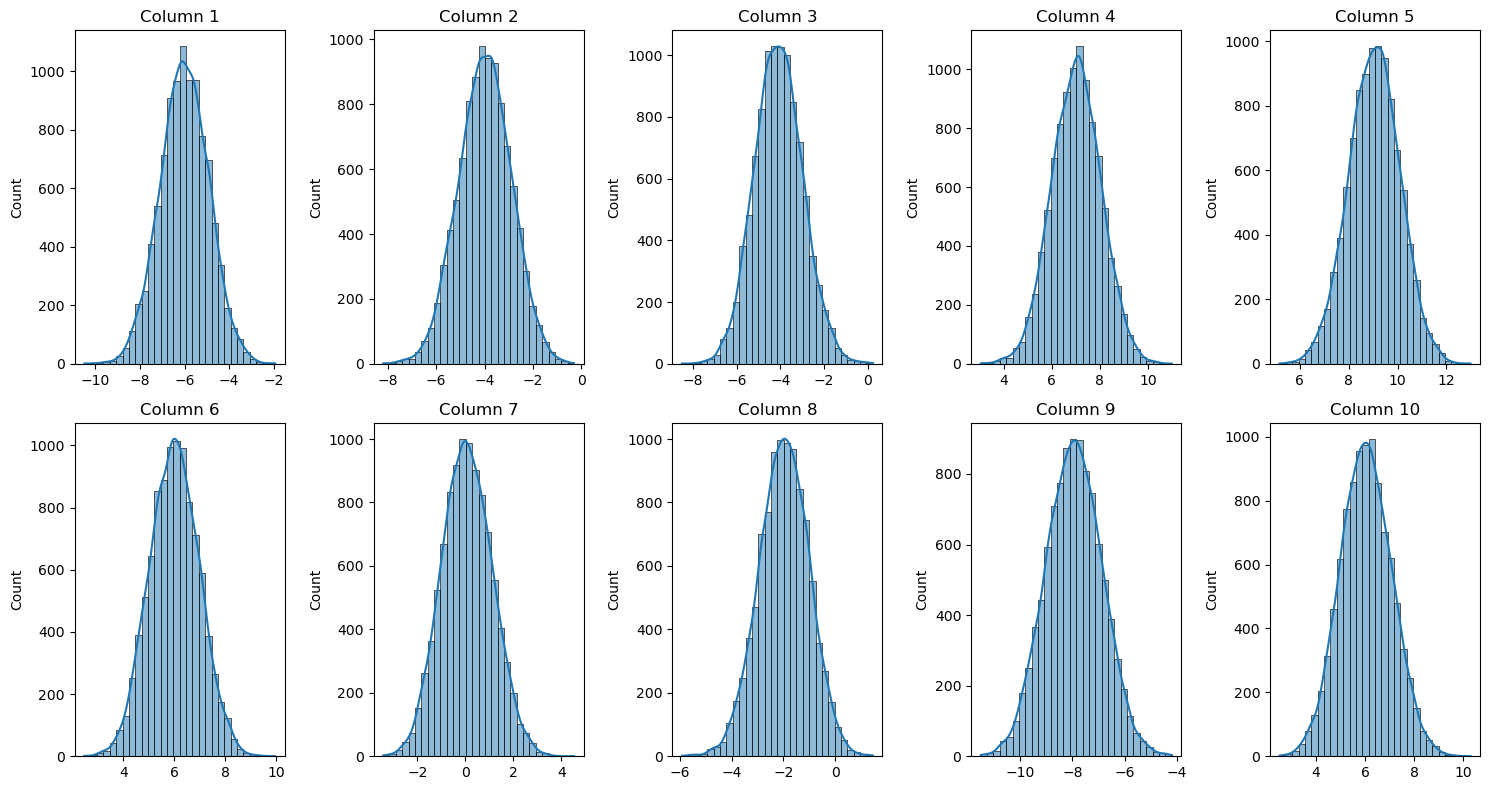

In [33]:
sampling_number = 10000
only_final = True
sample = process.sampling(sampling_number, only_final)
sample =sc.inverse_transform(sample.cpu().detach().numpy())
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

for i in range(10):
    sns.histplot(sample[:, i], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Column {i+1}') 


plt.tight_layout()

# Show the plot
plt.show()


conditional ddpm

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

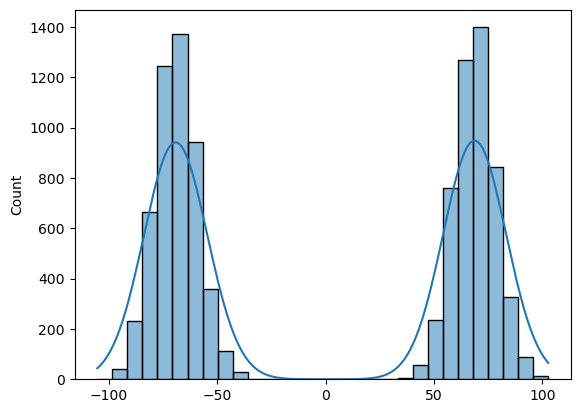

In [47]:
import numpy as np
import torch

# 生成双峰分布数据
data3 = np.random.multivariate_normal([3, 9], [[1, 0.5], [0.5, 1]], 10000)
coef1 = [5, 6]
coef2 = [-5, -6]
noise = np.random.randn(10000)

# 生成双峰目标变量
data4_1 = data3[:, 0] * coef1[0] + data3[:, 1] * coef1[1] + noise
data4_2 = data3[:, 0] * coef2[0] + data3[:, 1] * coef2[1] + noise
data4 = np.concatenate([data4_1[:5000], data4_2[5000:]])

# 合并数据
data = np.concatenate([data3, data4.reshape(-1, 1)], axis=1)
dataset = torch.tensor(data).float()
sns.histplot(data[:,-1], kde=True, bins=30)

In [41]:
class con_Backbone(nn.Module):
    def __init__(self, n_steps, input_dim = 1,con_dim=4):
        super().__init__()
        self.linear_model1 = nn.Sequential(
            nn.Linear(input_dim+con_dim, 32),
            nn.ReLU()
        )
        # Condition time t
        self.embedding_layer = nn.Embedding(n_steps, 32)
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(32+con_dim, 32),
            nn.ReLU(),
            
            nn.Linear(32, 64),
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, input_dim),
        )
    def forward(self, x, con_x,idx):   
        x = torch.cat((x, con_x), dim=1) 
        x = torch.cat((self.linear_model1(x)+self.embedding_layer(idx),con_x),dim = 1)
        x = self.linear_model2(x)
        return x
class Model(nn.Module):
    def __init__(self, device, beta_1, beta_T, T, input_dim,con_dim):
        '''
        The epsilon predictor of diffusion process.

        beta_1    : beta_1 of diffusion process
        beta_T    : beta_T of diffusion process
        T         : Diffusion Steps
        input_dim : a dimension of data

        '''
        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = con_Backbone(T, input_dim,con_dim)
        
        self.to(device = self.device)

    def loss_fn(self, x,con_x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        output, epsilon, alpha_bar = self.forward(x,con_x, idx=idx, get_target=True)
        loss = (output - epsilon).square().mean()
        return loss

        
    def forward(self, x,con_x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (epsilon prediction)

        '''

        if idx == None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device = self.device)
            used_alpha_bars = self.alpha_bars[idx][:, None]
            epsilon = torch.randn_like(x)
            x_tilde = torch.sqrt(used_alpha_bars) * x + torch.sqrt(1 - used_alpha_bars) * epsilon
            
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device = self.device).long()
            x_tilde = x
            

            
        output = self.backbone(x_tilde,con_x, idx)
        
        return (output, epsilon, used_alpha_bars) if get_target else output
class DiffusionProcess():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, shape,con_x):
        '''
        beta_1        : beta_1 of diffusion process
        beta_T        : beta_T of diffusion process
        T             : step of diffusion process
        diffusion_fn  : trained diffusion network
        shape         : data shape
        '''

        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])
        self.shape = shape
        
        self.diffusion_fn = diffusion_fn
        self.device = device

    
    def _one_diffusion_step(self, x,con_x):
        '''
        x   : perturbated data
        '''
        for idx in reversed(range(len(self.alpha_bars))):
            noise = torch.zeros_like(x) if idx == 0 else torch.randn_like(x)
            sqrt_tilde_beta = torch.sqrt((1 - self.alpha_prev_bars[idx]) / (1 - self.alpha_bars[idx]) * self.betas[idx])
            predict_epsilon = self.diffusion_fn(x,con_x, idx)
            mu_theta_xt = torch.sqrt(1 / self.alphas[idx]) * (x - self.betas[idx] / torch.sqrt(1 - self.alpha_bars[idx]) * predict_epsilon)
            x = mu_theta_xt + sqrt_tilde_beta * noise
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number,con_x, only_final=False):
        '''
        sampling_number : a number of generation
        only_final      : If True, return is an only output of final schedule step 
        '''
        if self.shape[0]==1:
            sample = torch.randn([sampling_number,*self.shape]).to(device = self.device).squeeze().reshape(-1,1)
        else:
            sample = torch.randn([sampling_number,*self.shape]).to(device = self.device).squeeze()
        sampling_list = []
        
        final = None
        for idx, sample in enumerate(self._one_diffusion_step(sample,con_x)):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'
scatter_range = [-10, 10]
total_iteration = 1000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')
dist1 = (3, 1) # mean : (3, 3), std : 1
dist2 = (-3, 1) # mean : (-3, -3), std : 1
probability = 0.2
batch_size =64
def traincon_ddpm(model,optimizer,num_epochs,targetdim,traindata_loader,valdata_loader,early_stopping):
    best_loss = float('inf')
    early_stopping_counter = 0
    for epoch in range(num_epochs):
        whole_loss = 0
        for i, batch in enumerate(traindata_loader):
            batch_size = batch.shape[0]
            if targetdim==1:
                batch = batch.cuda()
                y1 = batch[:,-1].reshape(-1,1).cuda()
                x1 = batch[:,:-1].cuda()
            else:
                batch = batch.cuda()
                y1 =  torch.Tensor(batch[:,-targetdim:]).cuda() 
                x1 = batch[:,:-targetdim].cuda()
            loss = model.loss_fn(y1,x1)
            whole_loss+=loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.update(loss.item())
        val_loss = 0
        with torch.no_grad():
            for val_batch in valdata_loader:
                if targetdim==1:
                    batch = val_batch.cuda()
                    y1 = batch[:,-1].reshape(-1,1).cuda()
                    x1 = batch[:,:-1].cuda()
                else:
                    batch = val_batch.cuda()
                    y1 =  torch.Tensor(batch[:,-targetdim:]).cuda() 
                    x1 = batch[:,:-targetdim].cuda()
                val_loss+=model.loss_fn(y1,x1)
            val_loss /= len(valdata_loader)
        if (epoch) % 20 == 0:
            print('epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, whole_loss/len(traindata_loader), val_loss.item()))
        loss_new = val_loss
        if loss_new < best_loss:
            best_loss = loss_new
            early_stopping_counter = 0
            print('epoch: {}, find new best loss: Train Loss: {:.4f}'.format(epoch,best_loss))
            print('-' * 10)
        else:
            early_stopping_counter += 1
        if early_stopping_counter == early_stopping:
            print("Early stopping after {} epochs".format(epoch))
            break
    

In [42]:
data

array([[  1.8624483 ,   9.00637574,  62.77924935],
       [  2.0779178 ,   7.68223057,  57.24881888],
       [  2.72437225,  11.38199057,  83.480385  ],
       ...,
       [  2.26188557,   8.79115575, -64.47467764],
       [  3.65479177,  10.12210581, -77.39288343],
       [  2.34974868,   8.43208981, -64.52614079]])

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
X_train_5, X_temp_5 = train_test_split(data, test_size=0.4, random_state=42)
X_val_5, X_test_5 = train_test_split(X_temp_5, test_size=0.5, random_state=42)

X_train_5 = pd.DataFrame(X_train_5)
X_test_5 = pd.DataFrame(X_test_5)
X_val_5 = pd.DataFrame(X_val_5)
condim = X_train_5.shape[1]-1
train_data = X_train_5
val_data = X_val_5
test_data = X_test_5
X_train_5 = np.array(train_data, dtype=np.float32)
X_val_5 = np.array(val_data, dtype=np.float32)
X_test_5 = np.array(test_data, dtype=np.float32)
resultdata = pd.DataFrame()
# 设置 'Weekly_Sales' 列的值为 vaedata 中的 'Weekly_Sales' 列的值
resultdata['test'] = X_test_5[:,-1]
scatrain5 = StandardScaler()
sca_X_train_5 = scatrain5.fit_transform(X_train_5)
scaval5 = StandardScaler()
sca_X_val_5 = scaval5.fit_transform(X_val_5)
scay5 = StandardScaler()
sca_Y_train_5 = scay5.fit_transform(X_train_5[:,-1].reshape(-1,1))
scatest5 = StandardScaler()
sca_X_test_5 = scatest5.fit_transform(X_test_5)
sca_traindata_loader_5 = DataLoader(sca_X_train_5, batch_size=64, shuffle=True)
sca_valdata_loader_5 = DataLoader(sca_X_val_5, batch_size=64, shuffle=True)
scatter_range = [-10, 10]
total_iteration = 1000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')
batch_size =64
beta_1 = 1e-4
beta_T = 0.02
T = 50
device = torch.device('cuda')
model = Model(device, beta_1, beta_T, T, 1,condim)
optim = torch.optim.Adam(model.parameters(), lr = 0.005)
process = DiffusionProcess(beta_1, beta_T, T, model, device, 1,condim)
traincon_ddpm(model,optim,500,1,sca_traindata_loader_5,sca_valdata_loader_5,100)

epoch: 0, Train Loss: 0.9344, Val Loss: 0.8027
epoch: 0, find new best loss: Train Loss: 0.8027
----------
epoch: 1, find new best loss: Train Loss: 0.4846
----------
epoch: 2, find new best loss: Train Loss: 0.3632
----------
epoch: 5, find new best loss: Train Loss: 0.3364
----------
epoch: 8, find new best loss: Train Loss: 0.3000
----------
epoch: 10, find new best loss: Train Loss: 0.2687
----------
epoch: 14, find new best loss: Train Loss: 0.2545
----------
epoch: 20, Train Loss: 0.2486, Val Loss: 0.3212
epoch: 27, find new best loss: Train Loss: 0.2433
----------
epoch: 31, find new best loss: Train Loss: 0.2375
----------
epoch: 40, Train Loss: 0.2588, Val Loss: 0.3140
epoch: 41, find new best loss: Train Loss: 0.2351
----------
epoch: 60, Train Loss: 0.2490, Val Loss: 0.2631
epoch: 67, find new best loss: Train Loss: 0.2317
----------
epoch: 80, Train Loss: 0.2422, Val Loss: 0.2395
epoch: 82, find new best loss: Train Loss: 0.2257
----------
epoch: 94, find new best loss: Tra

In [44]:
sampling_number = sca_X_test_5.shape[0]
only_final = True
process = DiffusionProcess(beta_1, beta_T, T, model, device, (1,),torch.Tensor(sca_X_test_5[:,:-1]).cuda())
sample = process.sampling(sampling_number,torch.Tensor(sca_X_test_5[:,:-1]).cuda(),only_final)
trandatacvae = scay5.inverse_transform(sample.cpu().detach().numpy())

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


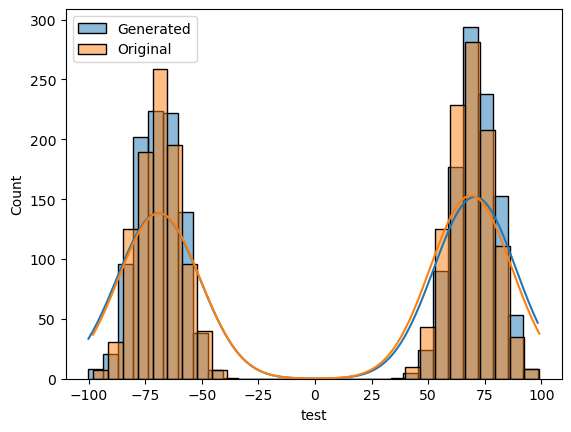

In [49]:
sns.histplot(trandatacvae, kde=True, bins=30, label='Generated')
sns.histplot(resultdata['test'], kde=True, bins=30, label='Original')
plt.legend()  # 添加图例